# How to build a Recurrent Neural Network in TensorFlow
In this tutorial I’ll explain how to build a simple working Recurrent Neural Network in TensorFlow. This is the first in a series of several parts where various aspects and techniques of building Recurrent Neural Networks in TensorFlow are covered. For now, let’s get started with the RNN!

## What is a RNN?
It is short for “Recurrent Neural Network”, and is basically a neural network that can be used when your data is treated as a sequence, where the particular order of the data-points matter. More importantly, this sequence can be of arbitrary length.
The most straight-forward example is perhaps a time-series of numbers, where the task is to predict the next value given previous values. The input to the RNN at every time-step is the current value as well as a state vector which represent what the network has “seen” at time-steps before. This state-vector is the encoded memory of the RNN, initially set to zero.

![Schematic of a RNN processing sequential data over time.](images/rnn-unrolled.png)

The best and most comprehensive article explaining RNN:s I’ve found so far is [this article](https://arxiv.org/pdf/1506.00019.pdf) by researchers at UCSD, highly recommended. For now you only need to understand the basics, read it until the “Modern RNN architectures”-section. That will be covered later.
Although this article contains some explanations, it is mostly focused on the practical part, how to build it. You are encouraged to look up more theory on the Internet, there are plenty of good explanations.

## Generate data

In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class DataSet(object):
    def __init__(self, binary_dim=8):
        self.binary_dim = binary_dim
        self.largest_number = pow(2, self.binary_dim)
        self.batch_id = 0
    def next(self, batch_size=5):
        x = []
        y = []
        for i in range(batch_size):
            a_int = np.random.randint(self.largest_number/2)
            b_int = np.random.randint(self.largest_number/2)
            c_int = a_int + b_int
            x1 = np.unpackbits(np.array([a_int], dtype=np.uint8))
            x2 = np.unpackbits(np.array([b_int], dtype=np.uint8))
            y1 = np.unpackbits(np.array([c_int], dtype=np.uint8))
            x1 = x1[::-1]
            x2 = x2[::-1]
            y1 = y1[::-1]
            x.append(np.array([x1, x2]).T)
            y.append(y1)
        return x, y

## Visualizing the stats

In [2]:
def printStats(epoch_idx, total_loss, batchX, predictions_series):
    index = np.random.randint(batch_size)
    x = (batchX[index]).T
    a = [0,0]
    for i,b in enumerate(x):
        for j,k in enumerate(b):
            a[i] += k*pow(2,j)

    one_hot = np.array(predictions_series)[:, index, :]
    y = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot])
    c = 0
    for i,b in enumerate(y):
        c += b*pow(2,i)

    print("Step:",epoch_idx, "Loss:", total_loss, "Example:", a[0], "+", a[1], "=", c)

## Visualizing the training

In [3]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(min(5, batch_size)):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchY[batch_series_idx] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


## Setup

In [4]:
num_epochs = 250
truncated_backprop_length = 8
state_size = 8
num_classes = 2
batch_size = 256
learning_rate = 0.5

trainset = DataSet()

## Building the computational graph
TensorFlow works by first building up a computational graph, that specifies what operations will be done. The input and output of this graph is typically multidimensional arrays, also known as tensors. The graph, or parts of it can then be executed iteratively in a session, this can either be done on the CPU, GPU or even a resource on a remote server.

### Variables and placeholders
The two basic TensorFlow data-structures that will be used in this example are placeholders and variables. On each run the batch data is fed to the placeholders, which are “starting nodes” of the computational graph. Also the RNN-state is supplied in a placeholder, which is saved from the output of the previous run.

In [5]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length, 2])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

The weights and biases of the network are declared as TensorFlow variables, which makes them persistent across runs and enables them to be updated incrementally for each batch.

In [6]:
W = tf.Variable(2*np.random.random((state_size+2, state_size))-1, dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(2*np.random.random((state_size, num_classes))-1,dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

### Unpacking
Now it’s time to build the part of the graph that resembles the actual RNN computation, first we want to split the batch data into adjacent time-steps.

In [7]:
# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)
print("inputs_series: ", inputs_series)
print()
print("labels_series: ", labels_series)
print()

inputs_series:  [<tf.Tensor 'unstack:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'unstack:1' shape=(256, 2) dtype=float32>, <tf.Tensor 'unstack:2' shape=(256, 2) dtype=float32>, <tf.Tensor 'unstack:3' shape=(256, 2) dtype=float32>, <tf.Tensor 'unstack:4' shape=(256, 2) dtype=float32>, <tf.Tensor 'unstack:5' shape=(256, 2) dtype=float32>, <tf.Tensor 'unstack:6' shape=(256, 2) dtype=float32>, <tf.Tensor 'unstack:7' shape=(256, 2) dtype=float32>]

labels_series:  [<tf.Tensor 'unstack_1:0' shape=(256,) dtype=int32>, <tf.Tensor 'unstack_1:1' shape=(256,) dtype=int32>, <tf.Tensor 'unstack_1:2' shape=(256,) dtype=int32>, <tf.Tensor 'unstack_1:3' shape=(256,) dtype=int32>, <tf.Tensor 'unstack_1:4' shape=(256,) dtype=int32>, <tf.Tensor 'unstack_1:5' shape=(256,) dtype=int32>, <tf.Tensor 'unstack_1:6' shape=(256,) dtype=int32>, <tf.Tensor 'unstack_1:7' shape=(256,) dtype=int32>]



### Forward pass
Next let’s build the part of the graph that does the actual RNN computation.

In [8]:
# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, -1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state
print("states_series: ", states_series)
print()
print("current_series: ", current_state)
print()

states_series:  [<tf.Tensor 'Tanh:0' shape=(256, 8) dtype=float32>, <tf.Tensor 'Tanh_1:0' shape=(256, 8) dtype=float32>, <tf.Tensor 'Tanh_2:0' shape=(256, 8) dtype=float32>, <tf.Tensor 'Tanh_3:0' shape=(256, 8) dtype=float32>, <tf.Tensor 'Tanh_4:0' shape=(256, 8) dtype=float32>, <tf.Tensor 'Tanh_5:0' shape=(256, 8) dtype=float32>, <tf.Tensor 'Tanh_6:0' shape=(256, 8) dtype=float32>, <tf.Tensor 'Tanh_7:0' shape=(256, 8) dtype=float32>]

current_series:  Tensor("Tanh_7:0", shape=(256, 8), dtype=float32)



### Calculating loss
This is the final part of the graph, a fully connected softmax layer from the state to the output that will make the classes one-hot encoded, and then calculating the loss of the batch.

In [9]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]
print("logits_series: ", logits_series)
print()

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

logits_series:  [<tf.Tensor 'add_8:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'add_9:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'add_10:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'add_11:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'add_12:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'add_13:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'add_14:0' shape=(256, 2) dtype=float32>, <tf.Tensor 'add_15:0' shape=(256, 2) dtype=float32>]



## Running a training session
It’s time to wrap up and train the network, in TensorFlow the graph is executed in a session. New data is generated on each epoch (not the usual way to do it, but it works in this case since everything is predictable).

Step: 0 Loss: 0.834593 Example: 92 + 63 = 0
Step: 20 Loss: 0.69422 Example: 47 + 15 = 88
Step: 40 Loss: 0.68858 Example: 74 + 102 = 218
Step: 60 Loss: 0.680007 Example: 109 + 78 = 221
Step: 80 Loss: 0.671441 Example: 46 + 99 = 46
Step: 100 Loss: 0.649825 Example: 42 + 28 = 122
Step: 120 Loss: 0.587651 Example: 90 + 58 = 246
Step: 140 Loss: 0.424156 Example: 80 + 100 = 148
Step: 160 Loss: 0.273632 Example: 66 + 34 = 228
Step: 180 Loss: 0.0610362 Example: 91 + 98 = 189
Step: 200 Loss: 0.0374764 Example: 89 + 90 = 179
Step: 220 Loss: 0.027402 Example: 44 + 49 = 93
Step: 240 Loss: 0.0207118 Example: 20 + 1 = 21


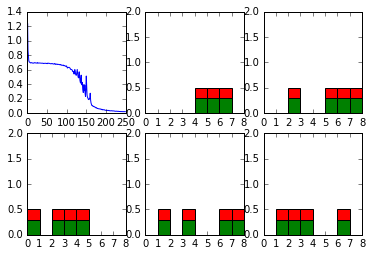

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    #plt.figure()
    plt.show()
    loss_list = []
    _current_state = np.zeros((batch_size, state_size))

    for epoch_idx in range(num_epochs):
        batchX,batchY = trainset.next(batch_size)
        _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

        loss_list.append(_total_loss)
        plot(loss_list, _predictions_series, batchX, batchY)

        if epoch_idx%20 == 0:
            printStats(epoch_idx, _total_loss, batchX, _predictions_series)
            
#plt.ioff()
plt.show()